In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

Import data

In [2]:
df = pd.read_csv('../trainDataset.csv')
df = df[~(df == 999).any(axis=1)]
df.drop('ID', axis=1, inplace=True)
for i in range(12, len(df.columns)):
    df.columns.values[i] = 'img_' + str(i)

df = df.reset_index()

In [6]:
df.columns[13]

'img_12'

In [46]:
#Tom's code to get rid of image outliers
threshold = 4 # standard deviations from mean (99.7% of data)
for i, col_name in enumerate(df.columns[13:]):
    col = df[col_name]
    mean = np.mean(col)
    std = np.std(col)
    for j, x in enumerate(col):
        z = (x - mean) / std
        if z > threshold:
            df.iloc[j, i] = mean

Triple-negative breast cancers are breast cancers not caused by the presence of ER receptors, PgR receptors, or the overexpression of the HER2 receptor. The information in the TripleNegative column is therefore redundant as it can be described by the ER, PgR, and HER2 columns whether a patient is triple-negative. To reduce dimensionality we have therefore removed the TripleNegative column. 

We drop the column TrippleNegative as this is information is already stored in the columns ER, PgR, and HER2
refernce for triple negative cancer being absense of the 3 hormone receptors - https://www.cancer.org/cancer/breast-cancer/about/types-of-breast-cancer/triple-negative.html

In [47]:
 # Assign features to X
X = df.drop('pCR (outcome)', axis=1).drop('RelapseFreeSurvival (outcome)', axis=1).drop('TrippleNegative', axis = 1)
X.drop('index', axis=1, inplace=True)

# Assign labels to y
y = df['pCR (outcome)']
X.head()

,Age,ER,PgR,HER2,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,img_12,...,img_109,img_110,img_111,img_112,img_113,img_114,img_115,img_116,img_117,img_118
0,41.0,0.0,0.0,0.0,3.0,3.0,1,1.0,2,0.813912,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,39.0,1.0,1.0,0.0,3.0,3.0,1,1.0,2,0.666118,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,31.0,0.0,0.0,0.0,2.0,1.0,1,0.0,2,0.645083,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,35.0,0.0,0.0,0.0,3.0,3.0,1,1.0,3,0.770842,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,61.0,1.0,0.0,0.0,2.0,1.0,1,0.0,2,0.861035,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


In [48]:
#scaling X data

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
Xs = scaler.fit_transform(X) 

We apply PCA before SMOTE. 
SMOTE is Synthetic Minority Oversampling Technique. When we originally attempted classification, we achieved a lower accuracy due the training data having majority pCR outcome of 0. This imbalanced training data lead to low sensitivity/recall. A balanced training dataset can be created using the SMOTE algorithm, a popular pre-processing technique used on cancer datasets (1), by creating synthetic instances with the pCR outcome of 1 (Srwa Hasan Abdulla). 

Chawla et al (look at paper)

https://machinelearningmastery.com/imbalanced-classification-model-to-detect-microcalcifications/ - Reference 1

"The Synthetic Minority Over-Sampling Technique (SMOTE) is a popular preprocess-ing approach for dealing with unbalanced datasets, inwhich the minority class is oversampled by creatingsynthetic instances in feature space" - Srwa Hasan Abdulla http://www.mendel-journal.org/index.php/mendel/article/view/144

In [49]:
from sklearn.decomposition import PCA

feature_names = list(X.columns) 
pca = PCA(n_components=0.90) # retain 90% of variance
img_pca = pca.fit_transform(Xs[:,9:]) #this number is 9 because after removing index, TrippleNegtaive, pCR outcome, RFS, that is the index of img_12  
print("N components:",pca.n_components_)

keep = 10
img_pca = img_pca[:,:keep] # retain the first 5 components
cols = ['pca_' + str(i+1) for i in range(keep)]
df_img_pca = pd.DataFrame(img_pca, columns=cols)

col_names = X.columns[:9]#this number is 9 because after removing index, TrippleNegtaive, pCR outcome, RFS, that is the index of img_12  
Xs_pca = pd.concat([pd.DataFrame(Xs[:,:9], columns=col_names), df_img_pca], axis=1)
Xs_pca

N components: 14


,Age,ER,PgR,HER2,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10
0,-0.999028,-0.271393,-0.189543,-0.167750,-0.087706,0.556626,-0.40519,-0.070851,-0.665396,-10.761034,2.153764,0.869801,4.194702,1.102865,0.675144,1.288586,-1.979458,-0.951462,-0.866735
1,-1.185279,0.137428,0.065586,-0.167750,-0.087706,0.556626,-0.40519,-0.070851,-0.665396,2.720475,-1.910036,-2.195710,1.288497,0.228938,-1.110859,0.479123,0.719937,-0.828635,0.629951
2,-1.930284,-0.271393,-0.189543,-0.167750,-0.088269,-0.325629,-0.40519,-0.072812,-0.665396,3.043981,-2.536804,-2.395347,1.995439,1.361412,-1.507142,1.266834,-0.893837,-0.194372,0.771146
3,-1.557782,-0.271393,-0.189543,-0.167750,-0.087706,0.556626,-0.40519,-0.070851,0.462884,5.330845,-1.888337,-2.399214,1.725467,-0.351177,-0.532732,0.973483,-0.364169,-0.755151,0.714709
4,0.863484,0.137428,-0.189543,-0.167750,-0.088269,-0.325629,-0.40519,-0.072812,-0.665396,1.555909,-3.023935,-2.498061,2.924556,1.236947,-1.640757,0.982017,0.995950,-0.320245,0.700626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,-0.524088,-0.271393,-0.189543,-0.167750,-0.087706,0.556626,-0.40519,-0.070851,1.591165,2.494626,0.781076,0.441391,-1.878376,-0.883220,0.624777,-1.676117,-2.604906,-1.064944,-0.534044
386,0.146417,-0.271393,-0.189543,-0.167750,-0.088269,-0.325629,-0.40519,-0.072812,-0.665396,2.479620,-4.217203,0.356904,-3.137702,4.811544,1.070098,0.930069,-1.291776,2.573965,-1.386682
387,1.589864,0.137428,-0.189543,-0.167750,-0.087706,0.556626,-0.40519,-0.070851,0.462884,-0.916396,0.415499,-0.270190,4.339634,-2.072451,0.891831,-2.478002,-1.684627,-2.029222,-0.634457
388,-0.533400,0.137428,-0.189543,-0.167750,-0.088269,-0.325629,-0.40519,-0.070851,-0.665396,2.291547,-3.212438,-0.855001,-2.639343,3.133676,-1.561611,1.295610,-2.043623,2.289645,0.332670


Tom's code: split data before SMOTE for true testing performance on unaltered population

In [50]:
_, Xs_test_original, _, y_test_original = train_test_split(Xs_pca, y, test_size=0.2, random_state=1, stratify=y) #Tom's code

In [51]:
from imblearn.over_sampling import SMOTE

Xs_pca_resampled, y_resampled = SMOTE().fit_resample(Xs_pca, y)

In [52]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs_pca_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled)

# Logistic Regression

Logistic Regression Model Accuracy : 0.6722689075630253
              precision    recall  f1-score   support

           0       0.68      0.64      0.66        59
           1       0.67      0.70      0.68        60

    accuracy                           0.67       119
   macro avg       0.67      0.67      0.67       119
weighted avg       0.67      0.67      0.67       119



Text(0, 0.5, 'Actual Values')

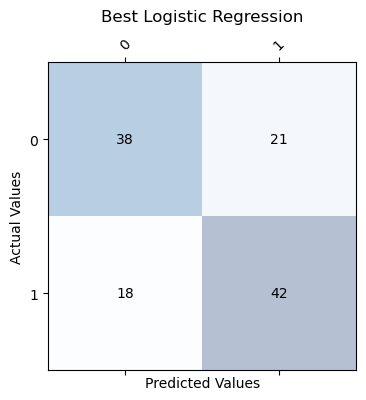

In [53]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(Xs_train,y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  

y_pred = model.predict(Xs_test)
print("Logistic Regression Model Accuracy : " + str(accuracy_score(y_test, y_pred))) #model accuracy

print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix, 
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
 for j in range(cm.shape[1]):
     ax.text(x=j, y=i,
         s=cm[i, j], 
         va='center', ha='center')
classes=["0","1"]
tick_marks = np.arange(len(classes))
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.title('Best Logistic Regression\n')
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('Actual Values', )

In [54]:
import sklearn.metrics as metrics

print(
    "Accuracy:\t", metrics.accuracy_score(y_pred, y_test),
    "\nPrecision:\t", metrics.precision_score(y_pred, y_test)
)

Accuracy:	 0.6722689075630253 
Precision:	 0.7


# SVM

In [55]:
#Separating some validation test data from the dataset before applying SMOTE
_, Xs_test_original, _, y_test_original = train_test_split(Xs_pca, y, test_size=0.2, random_state=1, stratify=y) #Tom's code

#Performing SMOTE 
from imblearn.over_sampling import SMOTE
Xs_pca_resampled, y_resampled = SMOTE().fit_resample(Xs_pca, y)

#Split into testing and training data
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs_pca_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled)


Did not include linear kernel in gridsearch as it showed poor computational performance. 

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

param_grid = {'C': [0.01, 0.05, 0.1,0.5, 1, 5, 10, 50, 100, 500, 1000], 'gamma': [1,0.05, 0.1,0.05, 0.01,0.005, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']} #Create a dictionary called param_grid and fill out some parameters for kernels, C and gamma
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2, cv=5) #Create a GridSearchCV object 
grid.fit(Xs_train,y_train) #fit object to the training data
print(grid.best_params_) #best parameters 

grid_predictions = grid.predict(Xs_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))#Output

Fitting 5 folds for each of 231 candidates, totalling 1155 fits
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.1s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.1s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.1s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.1s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.1s
[CV] END ....................C=0.01, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=0.01, gamma=1,

SVC(C=50, gamma=0.1) 0.8393952967525194


Text(0.5, 1.05, 'Best SVM\n')

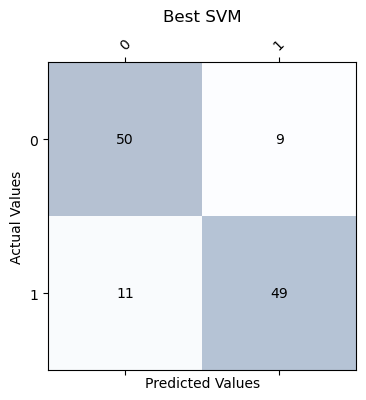

In [57]:
print(grid.best_estimator_, grid.best_score_)

model = grid.best_estimator_
model.fit(Xs_train,y_train)
y_pred = model.predict(Xs_test)

cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix, 
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
 for j in range(cm.shape[1]):
     ax.text(x=j, y=i,
         s=cm[i, j], 
         va='center', ha='center')
classes=["0","1"]
tick_marks = np.arange(len(classes))
fig = plt.gcf()
fig.set_size_inches(4,4)
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('Actual Values', )
plt.title('Best SVM\n')

In [30]:
import sklearn.metrics as metrics

print(
    "Accuracy:\t", metrics.accuracy_score(y_pred, y_test),
    "\nPrecision:\t", metrics.precision_score(y_pred, y_test)
)

Accuracy:	 0.865546218487395 
Precision:	 0.8833333333333333


## Logistic regression and SVM but substituting receptor columns with hormone column (still dropping TrippleNegative)

In [16]:
 # Assign features to X
X = df.drop('pCR (outcome)', axis=1).drop('RelapseFreeSurvival (outcome)', axis=1).drop('TrippleNegative', axis = 1)
X.insert(3,'Hormone',np.sum(df.iloc[:,4:7],axis = 1))
X = X.drop('ER',axis =1).drop('PgR',axis =1).drop('HER2',axis = 1)
X.drop('index', axis=1, inplace=True)

# Assign labels to y
y = df['pCR (outcome)']
X.head()

,Age,Hormone,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,img_12,img_13,img_14,...,img_109,img_110,img_111,img_112,img_113,img_114,img_115,img_116,img_117,img_118
0,41.0,0.0,3.0,3.0,1,1.0,2,0.813912,0.724080,23.781937,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,39.0,2.0,3.0,3.0,1,1.0,2,0.666118,0.476173,20.715461,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,31.0,0.0,2.0,1.0,1,0.0,2,0.645083,0.594470,21.659822,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,35.0,0.0,3.0,3.0,1,1.0,3,0.770842,0.501228,26.590504,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,61.0,1.0,2.0,1.0,1,0.0,2,0.861035,0.750267,20.456571,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


In [17]:
#scaling X data

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
Xs = scaler.fit_transform(X) 

In [18]:
from sklearn.decomposition import PCA

feature_names = list(X.columns) 
pca = PCA(n_components=0.90) # retain 90% of variance
img_pca = pca.fit_transform(Xs[:,7:]) #this number is 7 because after removing index, TrippleNegtaive, pCR outcome, RFS, that is the index of img_12  
print("N components:",pca.n_components_)

keep = 5
img_pca = img_pca[:,:keep] # retain the first 5 components
cols = ['pca_' + str(i+1) for i in range(keep)]
df_img_pca = pd.DataFrame(img_pca, columns=cols)

col_names = X.columns[:7]#this number is 9 because after removing index, TrippleNegtaive, pCR outcome, RFS, that is the index of img_12  
Xs_pca = pd.concat([pd.DataFrame(Xs[:,:7], columns=col_names), df_img_pca], axis=1)
Xs_pca

N components: 14


,Age,Hormone,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,pca_1,pca_2,pca_3,pca_4,pca_5
0,-0.999028,-0.221499,-0.087706,0.556626,-0.40519,-0.070851,-0.665396,-10.761034,2.153764,0.869801,4.194702,1.102865
1,-1.185279,-0.021179,-0.087706,0.556626,-0.40519,-0.070851,-0.665396,2.720475,-1.910036,-2.195710,1.288497,0.228938
2,-1.930284,-0.221499,-0.088269,-0.325629,-0.40519,-0.072812,-0.665396,3.043981,-2.536804,-2.395347,1.995439,1.361412
3,-1.557782,-0.221499,-0.087706,0.556626,-0.40519,-0.070851,0.462884,5.330845,-1.888337,-2.399214,1.725467,-0.351177
4,0.863484,-0.121339,-0.088269,-0.325629,-0.40519,-0.072812,-0.665396,1.555909,-3.023935,-2.498061,2.924556,1.236947
...,...,...,...,...,...,...,...,...,...,...,...,...
385,-0.524088,-0.221499,-0.087706,0.556626,-0.40519,-0.070851,1.591165,2.494626,0.781076,0.441391,-1.878376,-0.883220
386,0.146417,-0.221499,-0.088269,-0.325629,-0.40519,-0.072812,-0.665396,2.479620,-4.217203,0.356904,-3.137702,4.811544
387,1.589864,-0.121339,-0.087706,0.556626,-0.40519,-0.070851,0.462884,-0.916396,0.415499,-0.270190,4.339634,-2.072451
388,-0.533400,-0.121339,-0.088269,-0.325629,-0.40519,-0.070851,-0.665396,2.291547,-3.212438,-0.855001,-2.639343,3.133676


In [19]:
#Separating some validation test data from the dataset before applying SMOTE
_, Xs_test_original, _, y_test_original = train_test_split(Xs_pca, y, test_size=0.2, random_state=1, stratify=y) #Tom's code

#Performing SMOTE 
from imblearn.over_sampling import SMOTE
Xs_pca_resampled, y_resampled = SMOTE().fit_resample(Xs_pca, y)

#Split into testing and training data
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs_pca_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled)


Logistic Regression Model Accuracy : 0.6638655462184874
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        59
           1       0.64      0.77      0.70        60

    accuracy                           0.66       119
   macro avg       0.67      0.66      0.66       119
weighted avg       0.67      0.66      0.66       119



Text(0, 0.5, 'Actual Values')

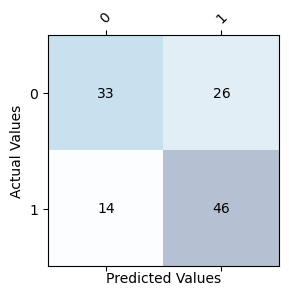

In [20]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(Xs_train,y_train)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  

y_pred = model.predict(Xs_test)
print("Logistic Regression Model Accuracy : " + str(accuracy_score(y_test, y_pred))) #model accuracy

print(classification_report(y_test,y_pred))
cm = confusion_matrix(y_test, y_pred)
# Plot confusion matrix, 
fig, ax = plt.subplots(figsize=(3, 3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
 for j in range(cm.shape[1]):
     ax.text(x=j, y=i,
         s=cm[i, j], 
         va='center', ha='center')
classes=["0","1"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('Actual Values', )

Logistic regression model performed worse when combining the hormone receptor data into one column 'Hormone'

SVM with hormone receptors in combined:

In [21]:
#Separating some validation test data from the dataset before applying SMOTE
_, Xs_test_original, _, y_test_original = train_test_split(Xs_pca, y, test_size=0.2, random_state=1, stratify=y) #Tom's code

#Performing SMOTE 
from imblearn.over_sampling import SMOTE
Xs_pca_resampled, y_resampled = SMOTE().fit_resample(Xs_pca, y)

#Split into testing and training data
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs_pca_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled)


from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC 

param_grid = {'C': [0.01, 0.05, 0.1,0.5, 1, 5, 10, 50, 100, 500, 1000], 'gamma': [1,0.05, 0.1,0.05, 0.01,0.005, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']} #Create a dictionary called param_grid and fill out some parameters for kernels, C and gamma
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2) #Create a GridSearchCV object 
grid.fit(Xs_train,y_train) #fit object to the training data
print(grid.best_params_) #best parameters 

grid_predictions = grid.predict(Xs_test)
print(confusion_matrix(y_test,grid_predictions))
print(classification_report(y_test,grid_predictions))#Output

Fitting 5 folds for each of 231 candidates, totalling 1155 fits
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.5s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.5s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.8s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.8s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.8s
[CV] END ....................C=0.01, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=0.01, gamma=1,

KeyboardInterrupt: 

In [ ]:
print(grid.best_score_)

SVC(C=5, gamma=0.1)

Likewise, could not improve accuracy of SVM

## Number of image components 

In [ ]:
 # Assign features to X
X = df.drop('pCR (outcome)', axis=1).drop('RelapseFreeSurvival (outcome)', axis=1).drop('TrippleNegative', axis = 1)
X.drop('index', axis=1, inplace=True)

# Assign labels to y
y = df['pCR (outcome)']
X.head()

,Age,ER,PgR,HER2,ChemoGrade,Proliferation,HistologyType,LNStatus,TumourStage,img_12,...,img_109,img_110,img_111,img_112,img_113,img_114,img_115,img_116,img_117,img_118
0,41.0,0,0,0,3,3,1,1,2,0.813912,...,0.517172,0.375126,3.325332,0.002314,3880771.500,473.464852,0.000768,0.182615,0.030508,0.000758
1,39.0,1,1,0,3,3,1,1,2,0.666118,...,0.444391,0.444391,3.032144,0.005612,2372009.744,59.459710,0.004383,0.032012,0.001006,0.003685
2,31.0,0,0,0,2,1,1,0,2,0.645083,...,0.534549,0.534549,2.485848,0.006752,1540027.421,33.935384,0.007584,0.024062,0.000529,0.006447
3,35.0,0,0,0,3,3,1,1,3,0.770842,...,0.506185,0.506185,2.606255,0.003755,6936740.794,46.859265,0.005424,0.013707,0.000178,0.004543
4,61.0,1,0,0,2,1,1,0,2,0.861035,...,0.462282,0.462282,2.809279,0.006521,1265399.054,39.621023,0.006585,0.034148,0.001083,0.005626


[0.5862068965517241, 0.591304347826087, 0.5087719298245614, 0.6614173228346456, 0.5982905982905983, 0.6190476190476191, 0.6299212598425197, 0.6666666666666667, 0.5689655172413793, 0.5882352941176471]


Text(0, 0.5, 'Testing Accuracy on Logistic Regression Model')

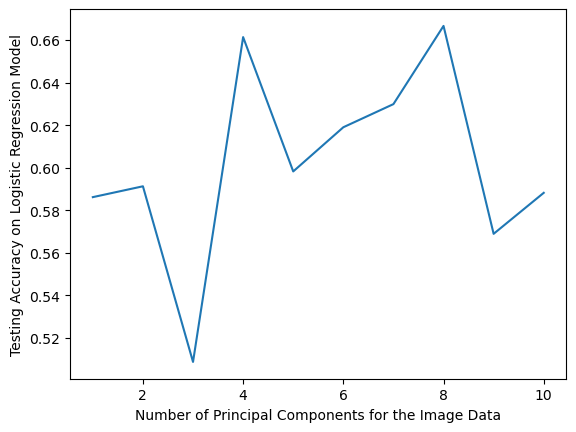

In [ ]:
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

feature_names = list(X.columns) 
pca = PCA(n_components=0.90) # retain 90% of variance
img_pca = pca.fit_transform(Xs[:,9:]) #this number is 9 because after removing index, TrippleNegtaive, pCR outcome, RFS, that is the index of img_12  

scores = []
for keep in range(1,11):
    img_pca_keep = img_pca[:,:keep] # retain the first 5 components
    cols = ['pca_' + str(i+1) for i in range(keep)]
    df_img_pca = pd.DataFrame(img_pca_keep, columns=cols)

    col_names = X.columns[:9]#this number is 9 because after removing index, TrippleNegtaive, pCR outcome, RFS, that is the index of img_12  
    Xs_pca = pd.concat([pd.DataFrame(Xs[:,:9], columns=col_names), df_img_pca], axis=1)
    
    
    #Separating some validation test data from the dataset before applying SMOTE
    _, Xs_test_original, _, y_test_original = train_test_split(Xs_pca, y, test_size=0.2, random_state=1, stratify=y) #Tom's code

    #Performing SMOTE 
    from imblearn.over_sampling import SMOTE
    Xs_pca_resampled, y_resampled = SMOTE().fit_resample(Xs_pca, y)

    #Split into testing and training data
    Xs_train, Xs_test, y_train, y_test = train_test_split(Xs_pca_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled) 

    #Logistic Regression
    model = LogisticRegression()
    model.fit(Xs_train,y_train)
    y_pred = model.predict(Xs_test)
    scores.append(f1_score(y_test, y_pred))

print(scores)
plt.plot(list(range(1,11)),scores)
plt.xlabel('Number of Principal Components for the Image Data')
plt.ylabel('Testing Accuracy on Logistic Regression Model')

Fitting 5 folds for each of 231 candidates, totalling 1155 fits
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ........................C=0.01, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   1.1s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.8s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   0.8s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   1.1s
[CV] END .......................C=0.01, gamma=1, kernel=poly; total time=   1.1s
[CV] END ....................C=0.01, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=0.01, gamma=1,

Text(0, 0.5, 'Testing Accuracy on SVM')

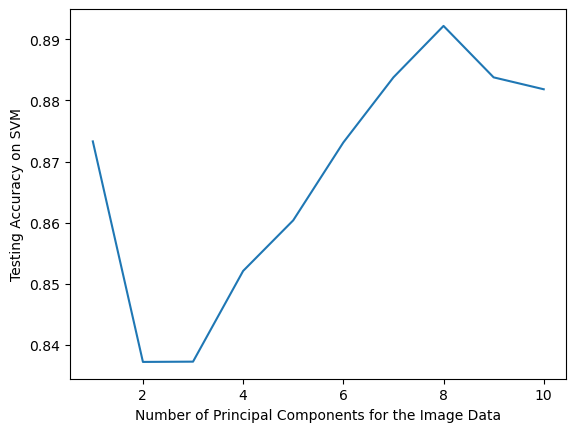

In [ ]:
from sklearn.decomposition import PCA

feature_names = list(X.columns) 
pca = PCA(n_components=0.90) # retain 90% of variance
img_pca = pca.fit_transform(Xs[:,9:]) #this number is 9 because after removing index, TrippleNegtaive, pCR outcome, RFS, that is the index of img_12  

scores = []
for keep in range(1,11):
    img_pca_keep = img_pca[:,:keep] # retain the first k components
    cols = ['pca_' + str(i+1) for i in range(keep)]
    df_img_pca = pd.DataFrame(img_pca_keep, columns=cols)

    col_names = X.columns[:9]#this number is 9 because after removing index, TrippleNegtaive, pCR outcome, RFS, that is the index of img_12  
    Xs_pca = pd.concat([pd.DataFrame(Xs[:,:9], columns=col_names), df_img_pca], axis=1)
    
    
    #Separating some validation test data from the dataset before applying SMOTE
    _, Xs_test_original, _, y_test_original = train_test_split(Xs_pca, y, test_size=0.2, random_state=1, stratify=y) #Tom's code

    #Performing SMOTE 
    from imblearn.over_sampling import SMOTE
    Xs_pca_resampled, y_resampled = SMOTE().fit_resample(Xs_pca, y)

    #Split into testing and training data
    Xs_train, Xs_test, y_train, y_test = train_test_split(Xs_pca_resampled, y_resampled, test_size=0.2, random_state=1, stratify=y_resampled) 

    from sklearn.model_selection import GridSearchCV
    from sklearn.svm import SVC 

    param_grid = {'C': [0.01, 0.05, 0.1,0.5, 1, 5, 10, 50, 100, 500, 1000], 'gamma': [1,0.05, 0.1,0.05, 0.01,0.005, 0.001],'kernel': ['rbf', 'poly', 'sigmoid']} #Create a dictionary called param_grid and fill out some parameters for kernels, C and gamma
    grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2) #Create a GridSearchCV object 
    grid.fit(Xs_train,y_train) #fit object to the training data
    scores.append(grid.best_score_)


print(scores)
plt.plot(list(range(1,11)),scores)
plt.xlabel('Number of Principal Components for the Image Data')
plt.ylabel('Testing Accuracy on SVM')

In [ ]:
grid.best_estimator_